# Setup

In [ ]:
%pip install torch-geometric

In [14]:
import os
import math
import time
import psutil
import random
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader


In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


In [3]:
def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

# Graph Classification

In [58]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split the dataset into train and test sets
mutag_train_dataset = mutag_data[:150]
mutag_test_dataset = mutag_data[150:]

# Create data loaders
mutag_train_loader = DataLoader(mutag_train_dataset, batch_size=32, shuffle=True)
mutag_test_loader = DataLoader(mutag_test_dataset, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = mutag_train_dataset.num_features
num_classes = mutag_test_dataset.num_classes

## GCN

In [49]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Training

In [50]:
def train_gcn(model, loader, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    
    
    # Train and test the models
    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()
        
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)  # Convert edge_index to adjacency matrix

            optimizer.zero_grad() 
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
    
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 


GCN1Layer(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Loss: 98.79984605312347
Time: 0.02s, CPU: 0.87GB, Memory: 2.91GB
Epoch 2, Loss: 93.58843433856964
Time: 0.01s, CPU: 2.00GB, Memory: 2.91GB
Epoch 3, Loss: 92.17313134670258
Time: 0.01s, CPU: 3.55GB, Memory: 2.92GB
Epoch 4, Loss: 90.86346876621246
Time: 0.01s, CPU: 0.80GB, Memory: 2.92GB
Epoch 5, Loss: 89.36487519741058
Time: 0.01s, CPU: 1.46GB, Memory: 2.92GB
Epoch 6, Loss: 87.82894384860992
Time: 0.01s, CPU: 2.66GB, Memory: 2.92GB
Epoch 7, Loss: 86.22932529449463
Time: 0.01s, CPU: 2.40GB, Memory: 2.92GB
Epoch 8, Loss: 84.52620923519135
Time: 0.01s, CPU: 2.66GB, Memory: 2.92GB
Epoch 9, Loss: 82.5999528169632
Time: 0.01s, CPU: 0.80GB, Memory: 2.92GB
Epoch 10, Loss: 80.77931725978851
Time: 0.01s, CPU: 1.00GB, Memory: 2.92GB
Epoch 11, Loss: 79.17482727766037
Time: 0.01s, CPU: 0.00GB, Memory: 2.92GB
Epoch 12, Loss: 77.81067842245102
Time: 0.01s,

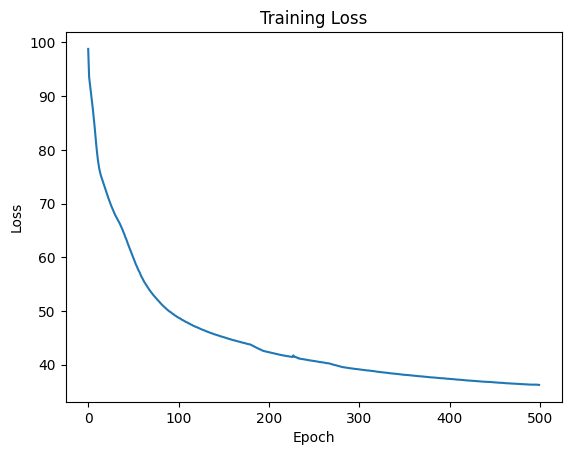

Model saved to models/gcn_1l.pth
Model saved to models/gcn_1l.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.18GB
Average Memory Usage: 2.91GB

Total Training Time: 6.03s
Max CPU Usage: 6.22GB
Max Memory Usage: 2.94GB


In [51]:
# Create model instances
model1 = GCN1Layer(num_features, num_classes)
print(model1)
print(f"Total number of trainable parameters: {(model1.count_parameters())*2}\n")
train_gcn(model1, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l_graph.pth')

GCN2Layer(
  (conv1): GCN (7 -> 64)
  (conv2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Loss: 97.16585290431976
Time: 0.02s, CPU: 1.81GB, Memory: 2.91GB
Epoch 2, Loss: 91.46142411231995
Time: 0.01s, CPU: 2.18GB, Memory: 2.91GB
Epoch 3, Loss: 88.28254663944244
Time: 0.01s, CPU: 2.40GB, Memory: 2.91GB
Epoch 4, Loss: 84.55763399600983
Time: 0.01s, CPU: 1.78GB, Memory: 2.91GB
Epoch 5, Loss: 80.75717496871948
Time: 0.01s, CPU: 1.60GB, Memory: 2.91GB
Epoch 6, Loss: 76.53260433673859
Time: 0.01s, CPU: 2.40GB, Memory: 2.91GB
Epoch 7, Loss: 73.58288276195526
Time: 0.01s, CPU: 0.00GB, Memory: 2.91GB
Epoch 8, Loss: 72.83806717395782
Time: 0.01s, CPU: 0.00GB, Memory: 2.91GB
Epoch 9, Loss: 71.83973115682602
Time: 0.01s, CPU: 0.00GB, Memory: 2.91GB
Epoch 10, Loss: 70.6589081287384
Time: 0.01s, CPU: 0.00GB, Memory: 2.91GB
Epoch 11, Loss: 70.30955308675766
Time: 0.01s, CPU: 0.00GB, Memory: 2.91GB
Epoch 12, Loss: 69.

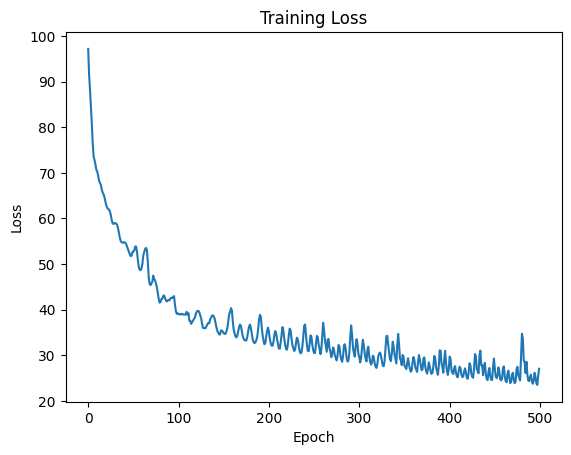

Model saved to models/gcn_2l.pth
Model saved to models/gcn_2l.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.13GB
Average Memory Usage: 2.91GB

Total Training Time: 6.10s
Max CPU Usage: 2.91GB
Max Memory Usage: 2.93GB


In [37]:
model2 = GCN2Layer(num_features, num_classes)
print(model2)
print(f"Total number of trainable parameters: {(model2.count_parameters())*2}\n")
train_gcn(model2, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l_graph.pth')

#### Evaluation

In [ ]:
def test_gcn(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return 

In [44]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l.pth'))
test_gcn(model1, mutag_test_loader)

print('\nModel 2-Layer GCN')
model2.load_state_dict(torch.load('models/gcn_2l.pth'))
test_gcn(model2, mutag_test_loader)

Model 1-Layer GCN
Accuracy: 0.7895
Sensitivity: 0.8077
Specificity: 0.7500

Model 2-Layer GCN
Accuracy: 0.8421
Sensitivity: 0.8462
Specificity: 0.8333


## Reservoir GCN

In [ ]:
class GCESN:
    def __init__(self, input_dim, reservoir_size, output_dim, spectral_radius=0.9, alpha=1e-6):
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.alpha = alpha

        self.initialize_weights()
        self.adjust_spectral_radius()
        
        self.readout = Ridge(alpha=self.alpha)
    
    def initialize_weights(self):
        self.Win = torch.rand((self.reservoir_size, self.input_dim)) * 2 - 1
        self.W = torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1
        self.adjust_spectral_radius()

    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

# Node Classification

In [59]:
# Load the Cora dataset
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
# transform=T.NormalizeFeatures()
cora_data = cora_dataset[0]

# Example of data attributes
print(cora_data)
print("Node feature shape:", cora_data.x.shape)
print("Edge index shape:", cora_data.edge_index.shape)
print("Number of classes:", cora_dataset.num_classes)
print("Number of node features:", cora_dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = cora_data.train_mask
val_mask = cora_data.val_mask
test_mask = cora_data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


Processing...
Done!


## GCN

In [65]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.gcn2 = GCN(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Training

In [66]:
def train_gcn(model, data, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    

    adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)  # Convert edge_index to adjacency matrix
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        optimizer.zero_grad()
        output = model(data.x, adj_matrix)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 



GCN1Layer(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Loss: 2.5315744876861572
Time: 0.05s, CPU: 0.95GB, Memory: 2.79GB
Epoch 2, Loss: 2.009591579437256
Time: 0.01s, CPU: 3.00GB, Memory: 2.79GB
Epoch 3, Loss: 1.7564932107925415
Time: 0.01s, CPU: 1.00GB, Memory: 2.79GB
Epoch 4, Loss: 1.6120637655258179
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 5, Loss: 1.497754693031311
Time: 0.01s, CPU: 3.20GB, Memory: 2.79GB
Epoch 6, Loss: 1.3904458284378052
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 7, Loss: 1.2899633646011353
Time: 0.01s, CPU: 3.00GB, Memory: 2.79GB
Epoch 8, Loss: 1.195993423461914
Time: 0.01s, CPU: 1.34GB, Memory: 2.79GB
Epoch 9, Loss: 1.1081916093826294
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 10, Loss: 1.025496482849121
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 11, Loss: 0.9445194602012634
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 12, Loss: 0.8635233640670776

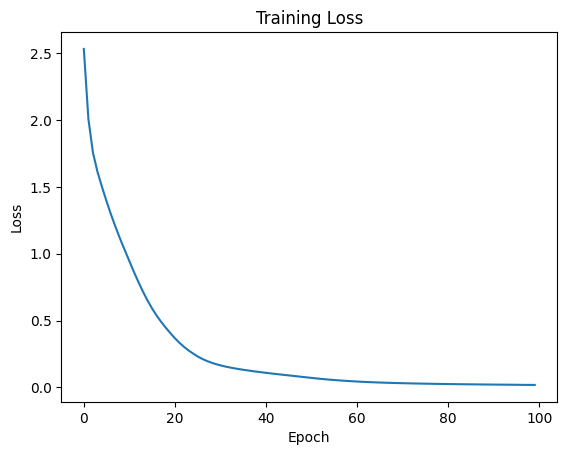

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.12GB
Average Memory Usage: 2.79GB

Total Training Time: 0.95s
Max CPU Usage: 3.20GB
Max Memory Usage: 2.79GB


In [68]:
# Create model instances
model1 = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(model1)
print(f"Total number of trainable parameters: {model1.count_parameters()}\n")
train_gcn(model1, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


GCN2Layer(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Loss: 2.840940237045288
Time: 0.02s, CPU: 0.80GB, Memory: 2.80GB
Epoch 2, Loss: 2.2725307941436768
Time: 0.02s, CPU: 2.40GB, Memory: 2.80GB
Epoch 3, Loss: 2.1306426525115967
Time: 0.02s, CPU: 4.40GB, Memory: 2.80GB
Epoch 4, Loss: 1.813894271850586
Time: 0.02s, CPU: 3.08GB, Memory: 2.80GB
Epoch 5, Loss: 1.5857995748519897
Time: 0.01s, CPU: 4.00GB, Memory: 2.80GB
Epoch 6, Loss: 1.5072133541107178
Time: 0.02s, CPU: 2.29GB, Memory: 2.80GB
Epoch 7, Loss: 1.4421696662902832
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 8, Loss: 1.3977277278900146
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 9, Loss: 1.3558145761489868
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 10, Loss: 1.3166905641555786
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 11, Loss: 1.2556278705596924
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 1

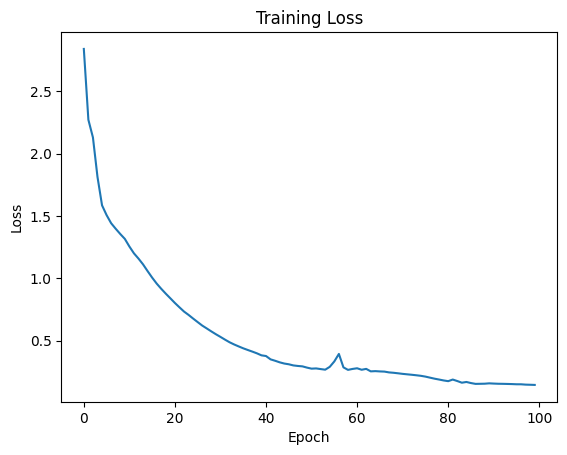

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.32GB
Average Memory Usage: 2.80GB

Total Training Time: 1.45s
Max CPU Usage: 4.40GB
Max Memory Usage: 2.80GB


In [70]:

model2 = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(model2)
print(f"Total number of trainable parameters: {model2.count_parameters()}\n")
train_gcn(model2, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

#### Testing

In [72]:
def test_gcn(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)
        output = model(data.x, adj_matrix)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return accuracy

In [74]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_gcn(model1, cora_data, cora_data.test_mask)

print('\nModel 2-Layer GCN')
model2.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_gcn(model2, cora_data, cora_data.test_mask)

Model 1-Layer GCN
Accuracy: 0.8493
Sensitivity: 0.9610
Specificity: 0.7246

Model 2-Layer GCN
Accuracy: 0.9529
Sensitivity: 0.9750
Specificity: 0.9333


0.9529411764705882

## Reservoir-GCN